In [1]:
!pip install fastai==1.0.42

    100% |████████████████████████████████| 163kB 4.8MB/s ta 0:00:01
  Found existing installation: fastai 1.0.45
    Uninstalling fastai-1.0.45:
      Successfully uninstalled fastai-1.0.45
You are using pip version 18.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [4]:
base_image_dir = "../input/dr-augmented/dr/upload/"
df = pd.read_csv("../input/dr-augmented/dr.csv")
df.columns = ['image', 'level']
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.png'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,3,../input/dr-augmented/dr/upload/30226_right.png
1,2,../input/dr-augmented/dr/upload/20060412_51677...
2,4,../input/dr-augmented/dr/upload/20051214_40912...
3,0,../input/dr-augmented/dr/upload/20051201_38246...
4,0,../input/dr-augmented/dr/upload/20051130_59457...
5,0,../input/dr-augmented/dr/upload/20051205_57651...
6,1,../input/dr-augmented/dr/upload/20060412_52978...
7,3,../input/dr-augmented/dr/upload/30922_left.png
8,0,../input/dr-augmented/dr/upload/20051020_64836...
9,1,../input/dr-augmented/dr/upload/20051202_48393...


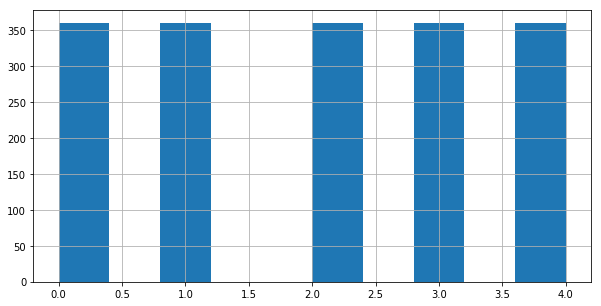

In [5]:
df['level'].hist(figsize = (10, 5))

In [6]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,360
1,360
2,360
3,360
4,360


This is a function to oversample the dataset (so some of the images of levels 1-4 are present multiple times in the dataset):

In [7]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

360

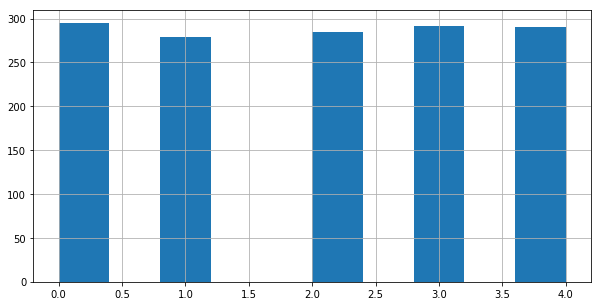

In [9]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [10]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,295
1,279
2,285
3,291
4,290


New Data Size: 1475 Old Size: 1440


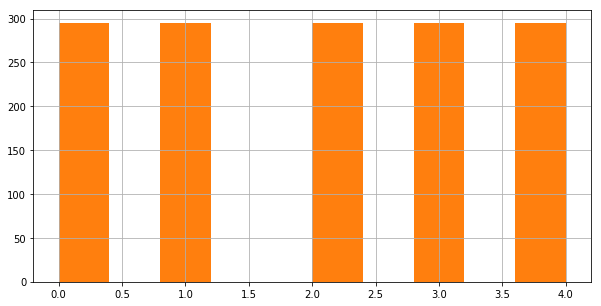

In [11]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [12]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

1835

In [13]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

300 300


The images are actually quite big. We will resize to a much smaller size and try to use progressive resizing to our advantage when dealing with such a small dataset.

In [14]:
bs = 32 #smaller batch size is better for training, but may take longer
sz=256

In [15]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

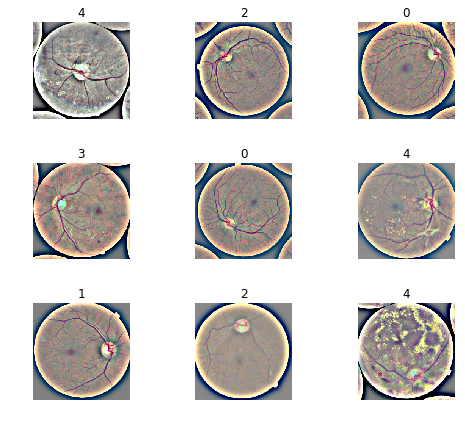

In [16]:
data.show_batch(rows=3, figsize=(7,6))

In [17]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4]


(5, 5)

In [18]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat,1), y, weights='quadratic'),device='cuda:0')

In [19]:
import torchvision
learn = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 36859471.90it/s]


In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


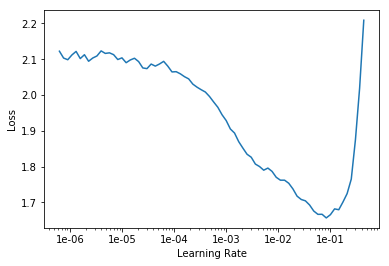

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(8,max_lr = 2e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,1.505452,1.126544,0.526316,0.763788
2,1.281700,1.170269,0.523546,0.735476
3,1.068285,1.005987,0.545706,0.787952
4,0.907746,0.944269,0.587258,0.823563
5,0.797689,0.929297,0.578947,0.821114
6,0.715047,0.890322,0.603878,0.826193
7,0.644821,0.890136,0.603878,0.829021
8,0.594649,0.894301,0.609418,0.837590


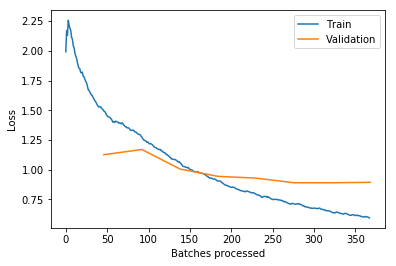

In [23]:
learn.recorder.plot_losses()

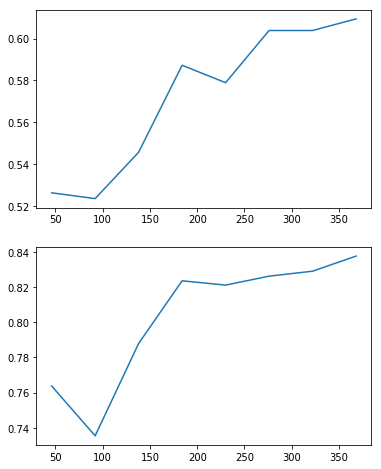

In [24]:
learn.recorder.plot_metrics()

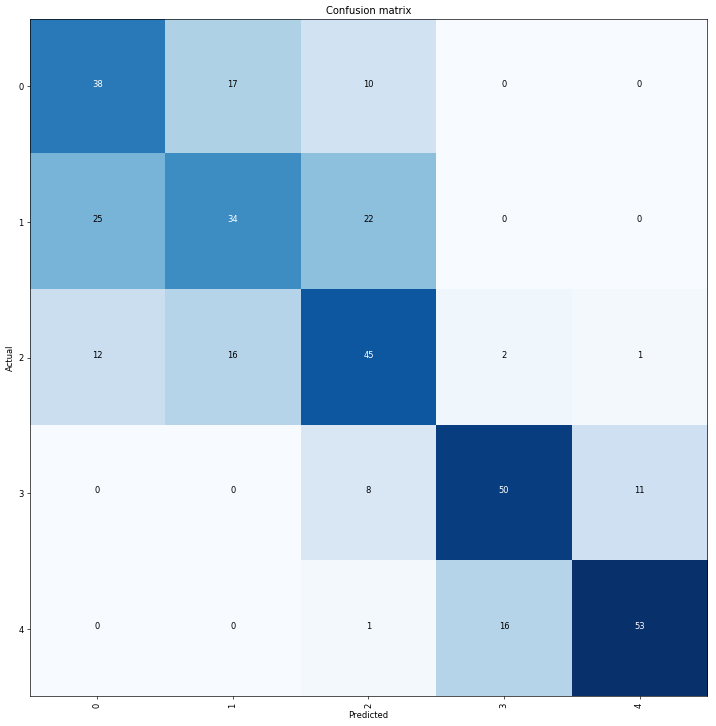

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
learn.save('stage-1-224')

In [27]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


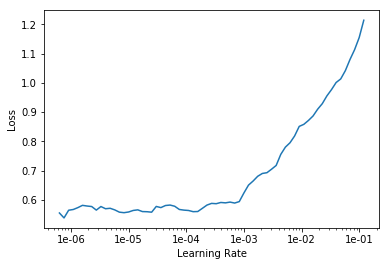

In [29]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.511426,0.906918,0.598338,0.844050
2,0.502630,0.907431,0.614958,0.839010
3,0.495075,0.914994,0.614958,0.844312
4,0.461731,0.927828,0.626039,0.855427


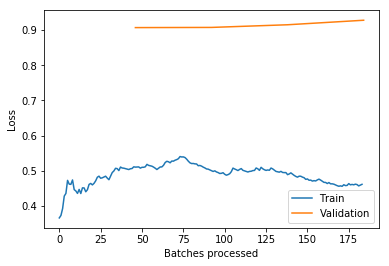

In [36]:
learn.recorder.plot_losses()

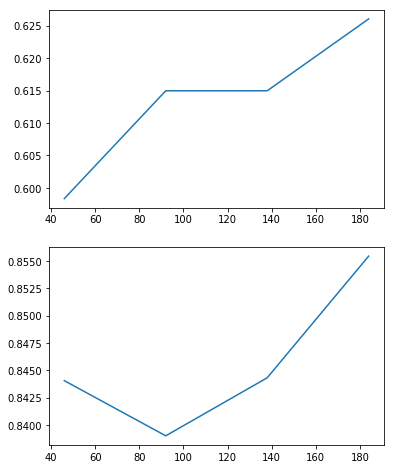

In [37]:
learn.recorder.plot_metrics()

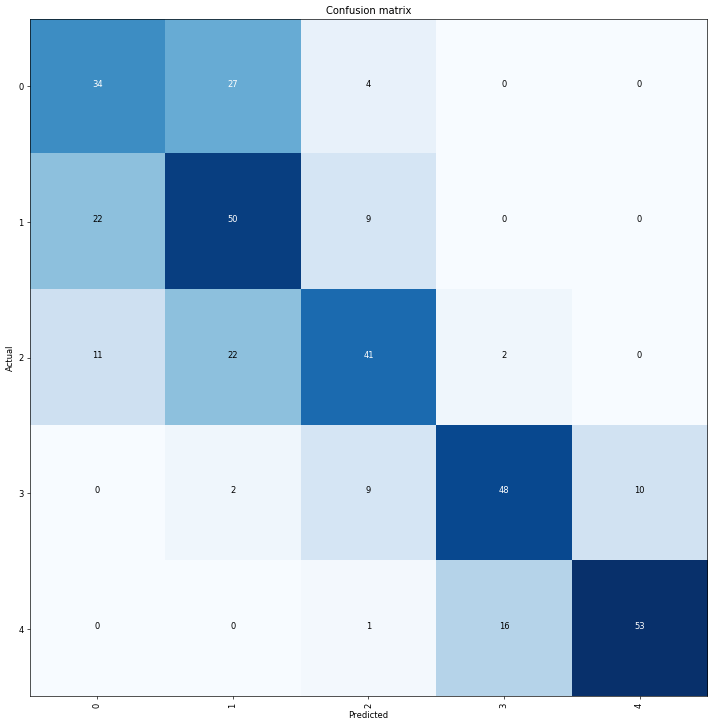

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [39]:
learn.save('stage-2-224')

In [40]:
data = (src.transform(tfms,size=sz*2) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [41]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [42]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


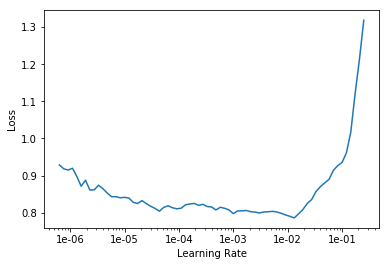

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(8 ,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.761367,0.883637,0.631579,0.852658
2,0.698702,0.826037,0.656510,0.876518
3,0.604136,0.868086,0.639889,0.853413
4,0.533799,0.848834,0.648199,0.871828


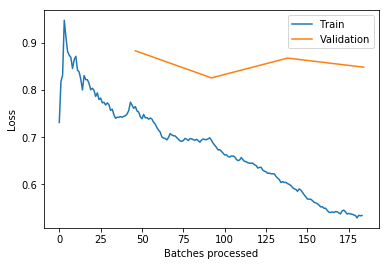

In [45]:
learn.recorder.plot_losses()

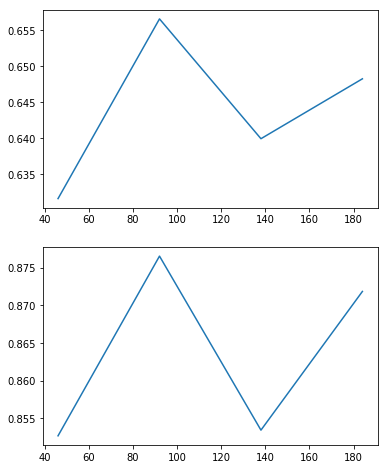

In [47]:
learn.recorder.plot_metrics()

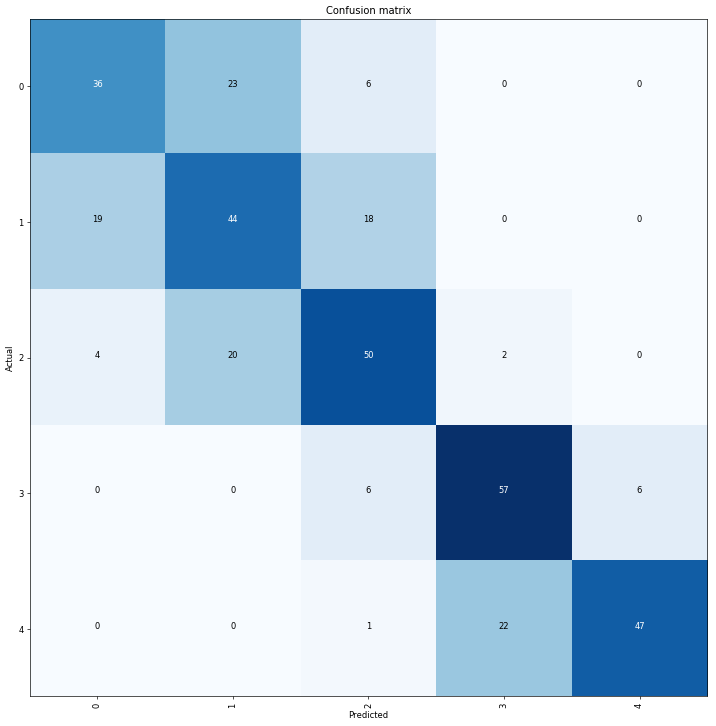

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [46]:
learn.save('stage-1-448')

In [49]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


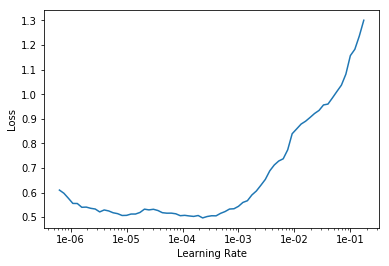

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(8,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.493895,0.847222,0.637119,0.860172
2,0.483333,0.823166,0.642659,0.862293
3,0.466598,0.836626,0.639889,0.869665
4,0.439615,0.828595,0.673130,0.874824
5,0.415925,0.834504,0.662050,0.864887
6,0.403920,0.837512,0.648199,0.852642
7,0.386149,0.833376,0.664820,0.862000
8,0.374115,0.829488,0.662050,0.858497


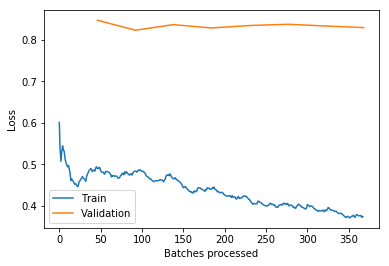

In [52]:
learn.recorder.plot_losses()

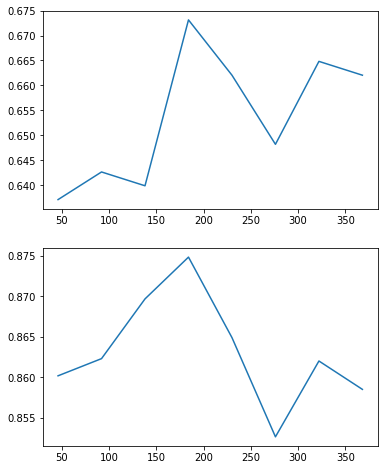

In [53]:
learn.recorder.plot_metrics()

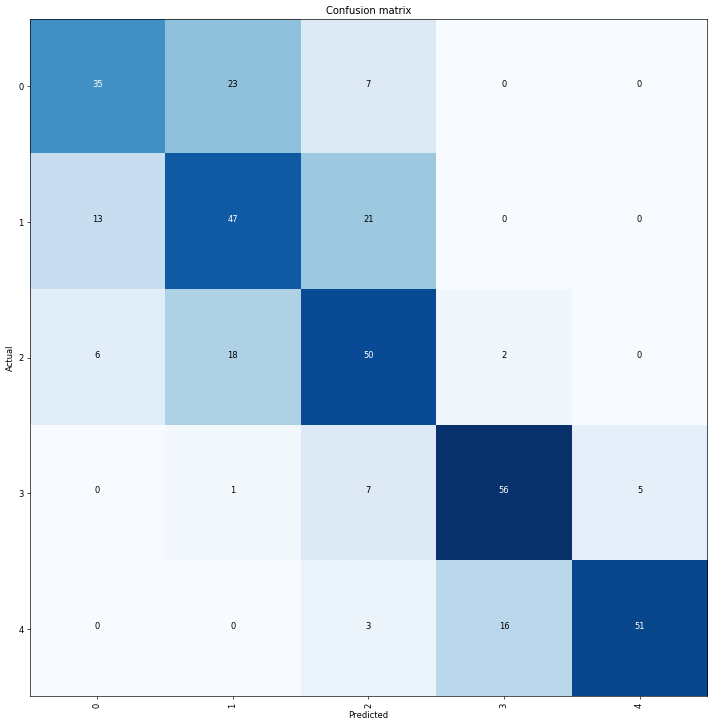

In [54]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [56]:
learn.save('stage-2-448')

In [68]:
base_image_dir = '../input/aptos-augmented/aptos/upload/'
df = pd.read_csv('../input/aptos-augmented/aptos.csv')
df.columns = ['image', 'level']
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.png'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,1,../input/aptos-augmented/aptos/upload/24e0b011...
1,3,../input/aptos-augmented/aptos/upload/2a70adad...
2,0,../input/aptos-augmented/aptos/upload/bab77613...
3,2,../input/aptos-augmented/aptos/upload/948f5be8...
4,0,../input/aptos-augmented/aptos/upload/a11c62cb...
5,4,../input/aptos-augmented/aptos/upload/35128d61...
6,0,../input/aptos-augmented/aptos/upload/51e656e5...
7,1,../input/aptos-augmented/aptos/upload/a0102405...
8,1,../input/aptos-augmented/aptos/upload/8cd25027...
9,4,../input/aptos-augmented/aptos/upload/8046a29a...


In [69]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2)

New Data Size: 8090 Old Size: 8000


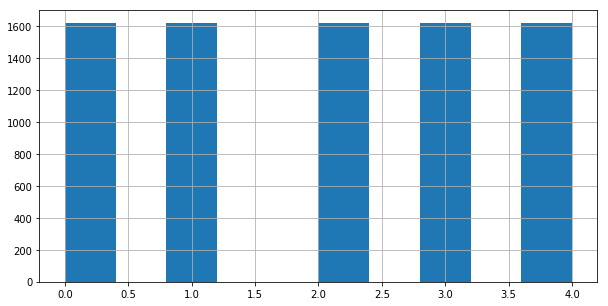

In [70]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df)

In [71]:
df = pd.concat([train_df,val_df])

In [72]:
bs = 32
sz = 256

In [73]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [74]:
learn.data = data

In [75]:
learn.freeze()

In [76]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


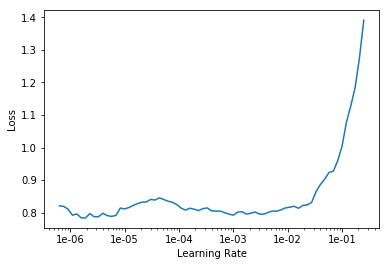

In [77]:
learn.recorder.plot()

In [78]:
learn.fit_one_cycle(8,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.784054,0.658987,0.727636,0.817937
2,0.705521,0.601466,0.760620,0.851046
3,0.620019,0.567877,0.774613,0.868382
4,0.558187,0.472323,0.808596,0.893980
5,0.486679,0.432073,0.839580,0.911213
6,0.417868,0.398423,0.849075,0.914420
7,0.360942,0.385479,0.849075,0.917036
8,0.363324,0.373422,0.857071,0.921585


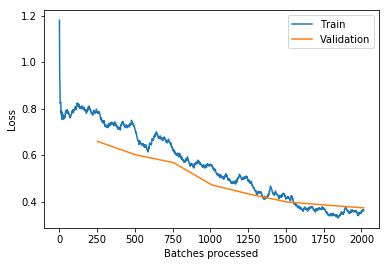

In [79]:
learn.recorder.plot_losses()

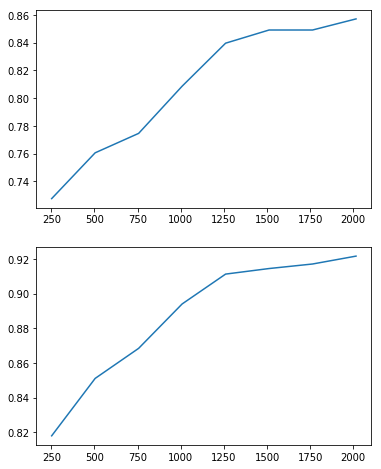

In [80]:
learn.recorder.plot_metrics()

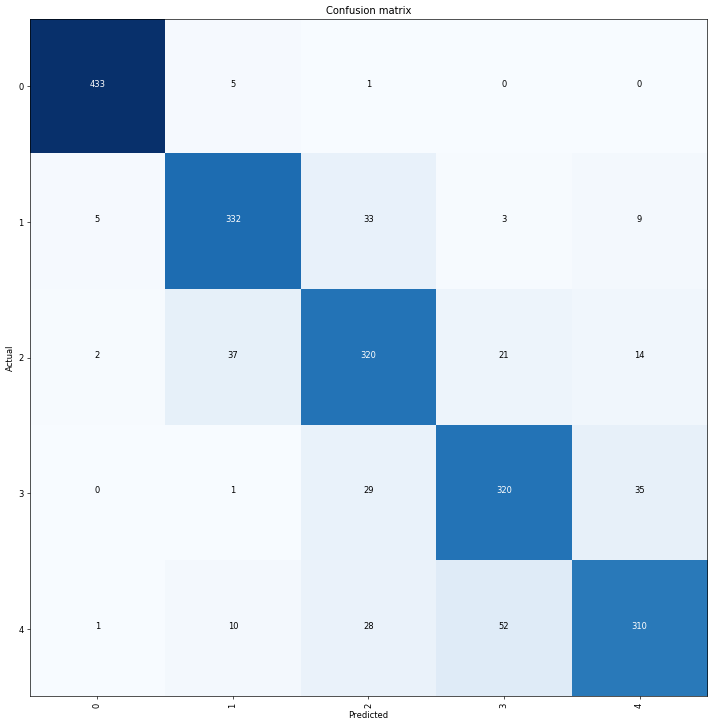

In [81]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [82]:
learn.save('stage-1-224')

In [83]:
learn.unfreeze()

In [84]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


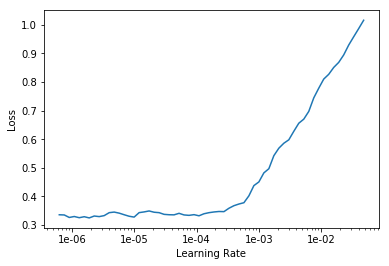

In [85]:
learn.recorder.plot()

In [86]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.330525,0.374853,0.857071,0.919992
2,0.331830,0.353187,0.864568,0.924665
3,0.319765,0.337673,0.872564,0.927937
4,0.263353,0.323509,0.880060,0.934677
5,0.249000,0.308937,0.887056,0.940704
6,0.249684,0.309921,0.883558,0.939784
7,0.217031,0.292693,0.892054,0.944054
8,0.211019,0.291454,0.891054,0.941904


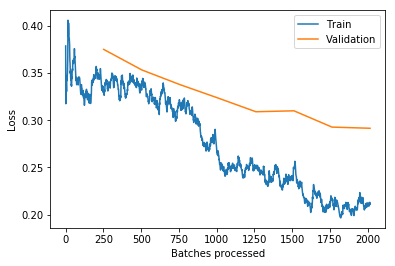

In [87]:
learn.recorder.plot_losses()

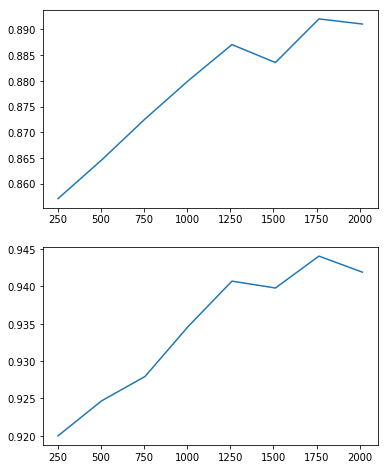

In [88]:
learn.recorder.plot_metrics()

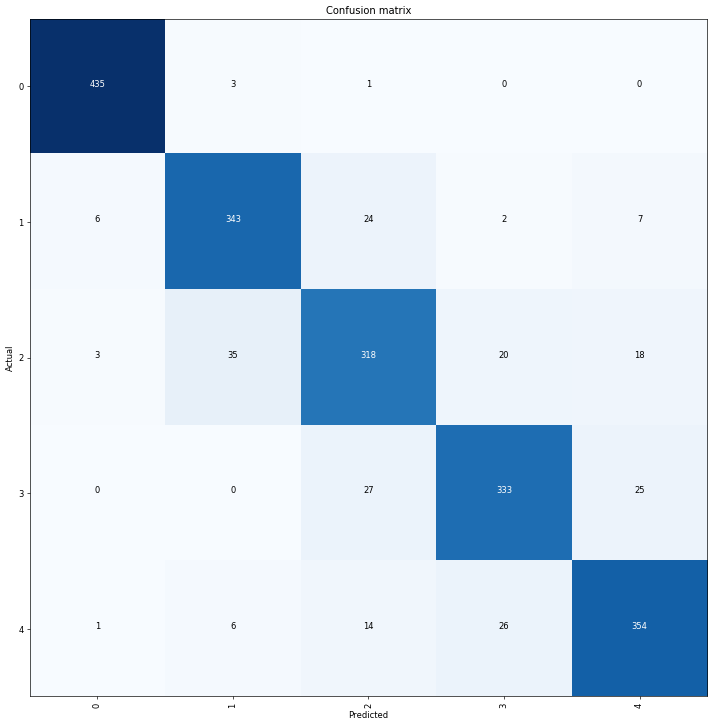

In [89]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [90]:
learn.save('stage-2-224')

In [91]:
data = (src.transform(tfms,size=sz*2) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [92]:
learn.data = data

In [93]:
learn.freeze()

In [94]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


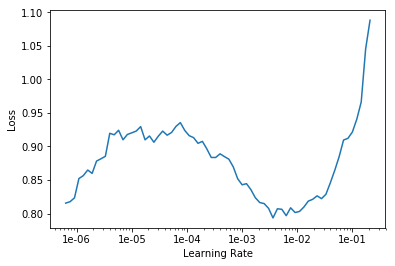

In [95]:
learn.recorder.plot()

In [96]:
learn.fit_one_cycle(8,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.520366,0.446791,0.821589,0.891084
2,0.427441,0.415476,0.836582,0.901243
3,0.365672,0.412310,0.838581,0.910214
4,0.322876,0.368726,0.863568,0.913230
5,0.285379,0.353516,0.866067,0.911534
6,0.226919,0.287885,0.897551,0.942857
7,0.200158,0.260506,0.908046,0.949574
8,0.184426,0.260885,0.909545,0.951161


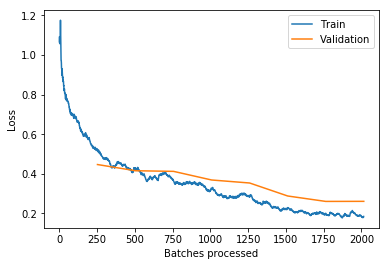

In [97]:
learn.recorder.plot_losses()

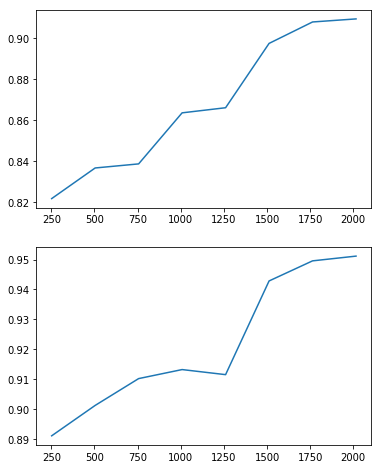

In [98]:
learn.recorder.plot_metrics()

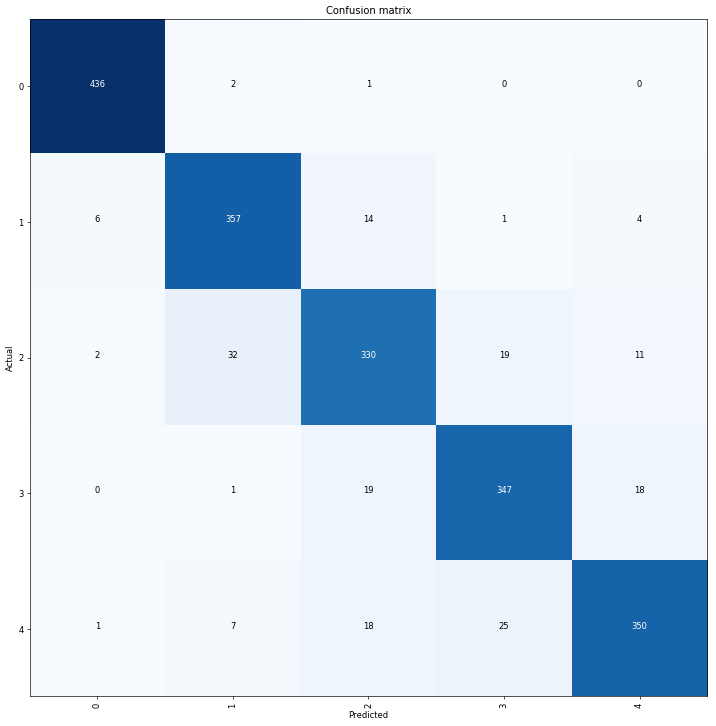

In [99]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [100]:
learn.save('stage-1-448')

In [101]:
learn.unfreeze()

In [102]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


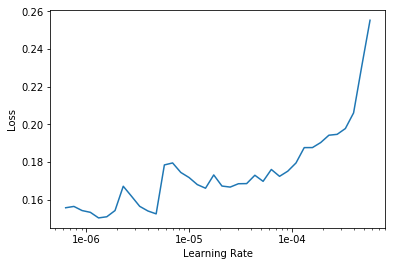

In [103]:
learn.recorder.plot()

In [104]:
learn.fit_one_cycle(8,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.188877,0.256894,0.910045,0.949824
2,0.171893,0.263714,0.906047,0.949339
3,0.174709,0.270682,0.904548,0.950082
4,0.160753,0.242582,0.926037,0.960606
5,0.141671,0.223188,0.923038,0.960003
6,0.127312,0.216402,0.926037,0.961256
7,0.119567,0.210920,0.926037,0.962506
8,0.098054,0.210612,0.929535,0.960922


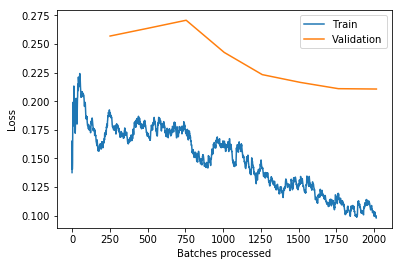

In [105]:
learn.recorder.plot_losses()

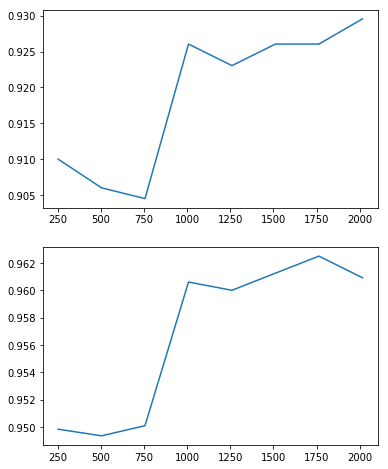

In [106]:
learn.recorder.plot_metrics()

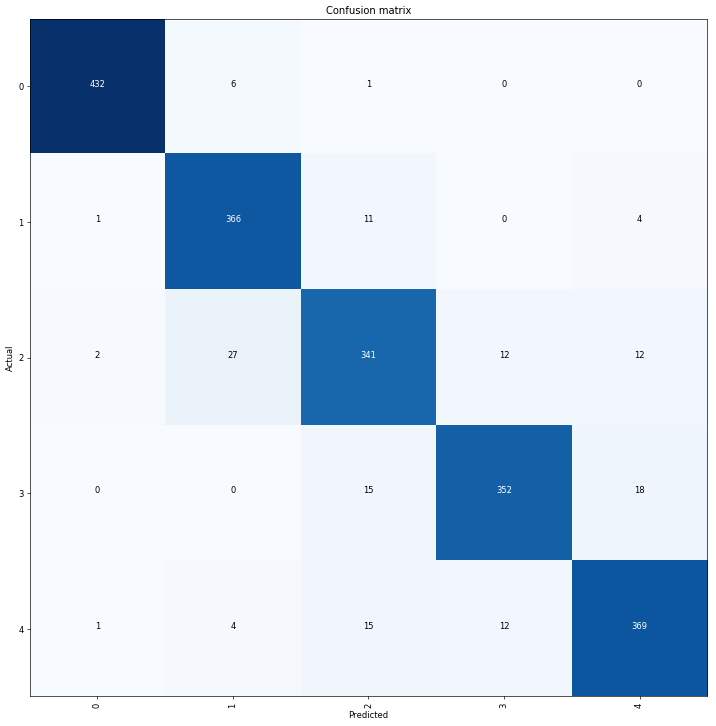

In [107]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [108]:
learn.save('stage-2-448')